# Clustering

Clustering techniques are unsupervised learning algorithms that try to group unlabelled data into "clusters", using the (typically spatial) structure of the data itself. It has many [applications](https://en.wikipedia.org/wiki/Cluster_analysis#Applications).

The easiest way to demonstrate how clustering works is to simply generate some data and show them in action. We'll start off by importing the libraries we'll be using today.

> Comment JH: use cluster analysis when dataset features are "similar" in the sense they represent similar things,

In [ ]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [ ]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create data

In [ ]:
n_clusters=6
n_samples =250

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

In [ ]:
centroids = torch.rand(n_clusters, 2)*70-35

In [ ]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

Multivariate Normal defined by means vector and covariance matrix (here we use a diagonal)

In [ ]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [ ]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

In [ ]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='yellow', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

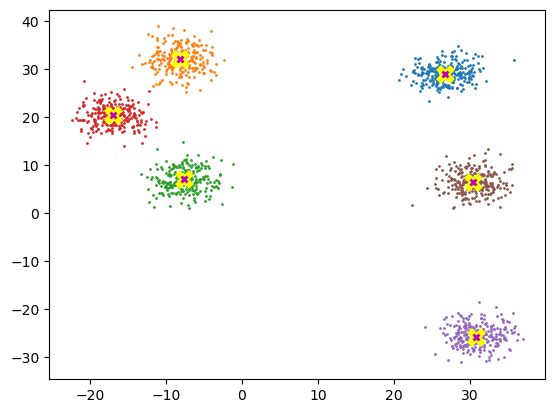

In [ ]:
plot_data(centroids, data, n_samples)

## Mean shift

Most people that have come across clustering algorithms have learnt about **k-means**. Mean shift clustering is a newer and less well-known approach, but it has some important advantages:
* It doesn't require selecting the number of clusters in advance, but instead just requires a **bandwidth** to be specified, which can be easily chosen automatically
* It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.

The algorithm is as follows:
* For each data point x in the sample X, find the distance between that point x and every other point in X
* Create weights for each point in X by using the **Gaussian kernel** of that point's distance to x
    * This weighting approach penalizes points further away from x
    * The rate at which the weights fall to zero is determined by the **bandwidth**, which is the standard deviation of the Gaussian
* Update x as the weighted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

In [ ]:
midp = data.mean(0)
midp

tensor([ 9.222, 11.604])

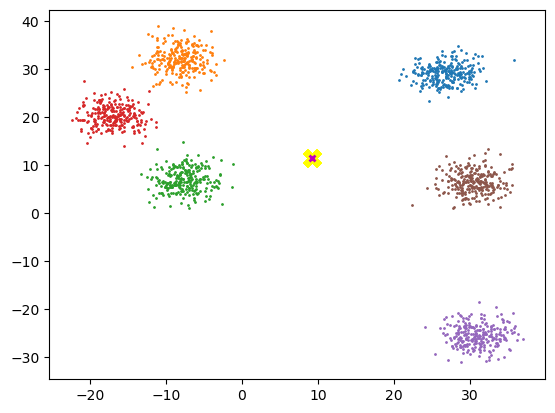

In [ ]:
plot_data([midp]*6, data, n_samples)

So here's the definition of the gaussian kernel, which you may remember from high school...

In [ ]:
def gaussian(d, bw): 
    return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [ ]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

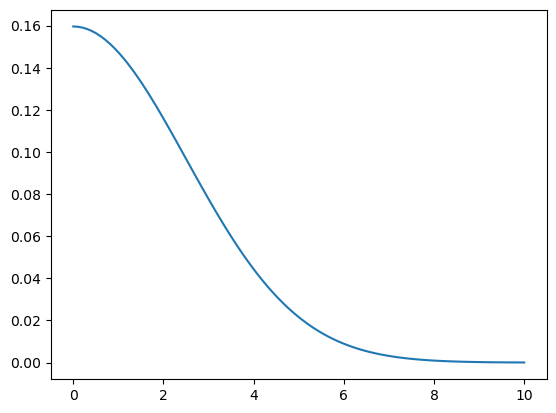

In [ ]:
plot_func(partial(gaussian, bw=2.5))

Usefull tool in Python: `partial`

In [ ]:
partial

functools.partial

Calling the function `partial` in the code cell returns the full name of the function, including its module `functools`

In our implementation, we choose the bandwidth to be 2.5. 

> One easy way to choose bandwidth is to find which bandwidth covers one third of the data.

Could also simplify the gaussian with a linear approximation

In [ ]:
def tri(d, i): return (-d+i).clamp_min(0)/i

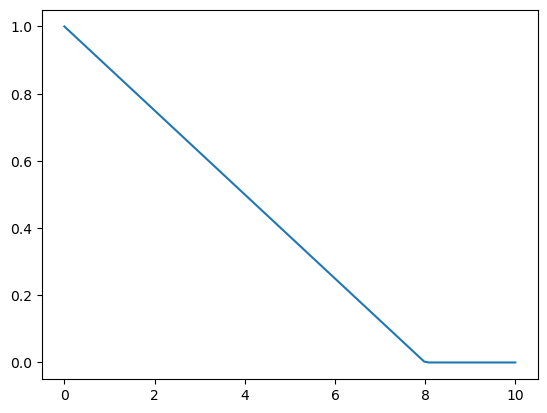

In [ ]:
plot_func(partial(tri, i=8))

In [ ]:
X = data.clone()
x = data[0]

In [ ]:
x

tensor([26.204, 26.349])

In [ ]:
x.shape,X.shape,x[None].shape

(torch.Size([2]), torch.Size([1500, 2]), torch.Size([1, 2]))

`x[None]` can be broadcasted to `X`

In [ ]:
(x[None]-X)[:8]

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        [ 0.557, -3.685],
        [-5.033, -3.745],
        [-4.073, -0.638],
        [-3.415, -5.601],
        [-1.920, -5.686]])

`x` also can be broadcasted to `X`

In [ ]:
(x-X)[:8]

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        [ 0.557, -3.685],
        [-5.033, -3.745],
        [-4.073, -0.638],
        [-3.415, -5.601],
        [-1.920, -5.686]])

Thanks to this broadcasting, it is easy to compute the distances between x and all datapoints in X

In [ ]:
dist = ((x-X)**2).sum(1).sqrt()
dist[:8]

tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002])

In [ ]:
dist = torch.sqrt(((x-X)**2).sum(1))
dist[:8]

tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002])

### Homework

Rewrite using torch einsum, get rig of .sum 

In [ ]:
x.shape, X.shape

(torch.Size([2]), torch.Size([1500, 2]))

In [ ]:
x[None, :].shape, (x - X).shape

(torch.Size([1, 2]), torch.Size([1500, 2]))

In [ ]:
dif = x - X
dif.shape

torch.Size([1500, 2])

`np.einsum('ij,jk->ik', A, B).`

Think of `'ij,jk->ik'` as split in two at the arrow `->`. 

- The left-hand part labels the axes of the input arrays: `'ij'` labels `A` and `'jk'` labels `B`. 

- The right-hand part of the string labels the axes of the single output array with the letters `'ik'`.

To understand how the output array is calculated, remember these three rules:

- **Repeating letters** between input arrays means that values along those axes will be **multiplied** together. The products make up the values for the output array.

- **Omitting** a letter from the output means that values along that axis will be **summed**.

We can return the unsummed axes in any order we like.

- If we leave out the arrow `'->'`, returns the labels that appeared once in alphabetical order (so in fact `'ij,jk->ik'` is equivalent to just `'ij,jk'`). 
- If we want to control what our output looked like we can choose the order of the output labels ourself. For example, `'ij,jk->ki'` delivers the transpose of the matrix multiplication.

In [ ]:
A = torch.tensor([0, 0, 0, 1, 1, 0, 1, 1]).reshape((4,2))
B = torch.tensor([1, 1, 1, 2, 2, 1, 2, 2]).reshape((4,2))
A, B

(tensor([[0, 0],
         [0, 1],
         [1, 0],
         [1, 1]]),
 tensor([[1, 1],
         [1, 2],
         [2, 1],
         [2, 2]]))

In [ ]:
torch.einsum('ij -> i', A), torch.einsum('ij -> i', B)

(tensor([0, 1, 1, 2]), tensor([2, 3, 3, 4]))

In [ ]:
(A - B) ** 2

tensor([[1, 1],
        [1, 1],
        [1, 1],
        [1, 1]])

In [ ]:
torch.einsum('ij -> i', (A-B)**2)

tensor([2, 2, 2, 2])

In [ ]:
(torch.einsum('ij -> i', (A-B)**2)).sqrt()

tensor([1.414, 1.414, 1.414, 1.414])

In [ ]:
x.shape, X.shape

(torch.Size([2]), torch.Size([1500, 2]))

In [ ]:
new_dist = torch.einsum('ij -> i', (x[None, :]-X)**2).sqrt()

In [ ]:
from fastcore.test import *
test_close(new_dist, dist)

In [ ]:
A = torch.tensor([0, 0, 0, 1, 1, 0, 1, 1]).reshape((4,2))
B = torch.tensor([1, 1, 1, 2, 2, 1, 2, 2]).reshape((4,2))
A, B

(tensor([[0, 0],
         [0, 1],
         [1, 0],
         [1, 1]]),
 tensor([[1, 1],
         [1, 2],
         [2, 1],
         [2, 2]]))

We should use weighted

In [ ]:
weight = gaussian(dist, 2.5)
weight

tensor([    0.160,     0.047,     0.025,  ...,     0.000,     0.000,     0.000])

In [ ]:
weight.shape,X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

Now we want the weighted average

$$\frac{\sum{w_i \times x_i}}{\sum{w_i}}$$

```python
weight * X
```
will not work, as it does not broadcast
```
---------------------------------------------------------------------------
RuntimeError                              Traceback (most recent call last)
/home/vtec/projects/fastai/course22p2/nbs/02_meanshift.ipynb Cell 48 in <cell line: 1>()
----> 1 weight * X

RuntimeError: The size of tensor a (1500) must match the size of tensor b (2) at non-singleton dimension 1
```

In [ ]:
weight.shape, X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [ ]:
weight[:,None].shape

torch.Size([1500, 1])

In [ ]:
weight[:,None]*X

tensor([[    4.182,     4.205],
        [    1.215,     1.429],
        [    0.749,     0.706],
        ...,
        [    0.000,     0.000],
        [    0.000,     0.000],
        [    0.000,     0.000]])

Summarize all relevant code into one function

In [ ]:
def one_update(X):
    for i, x in enumerate(X):
        dist = torch.sqrt(((x-X)**2).sum(1))
#         weight = gaussian(dist, 2.5)
        weight = tri(dist, 8)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [ ]:
def meanshift(data):
    X = data.clone()
    for it in range(5): one_update(X)
    return X

In [ ]:
%time X=meanshift(data)

CPU times: user 664 ms, sys: 0 ns, total: 664 ms
Wall time: 663 ms


We can see that mean shift clustering has almost reproduced our original clustering. The one exception are the very close clusters, but if we really wanted to differentiate them we could lower the bandwidth.

What is impressive is that this algorithm nearly reproduced the original clusters without telling it how many clusters there should be.

> x are shifted by 2 to allow to see the meanshift

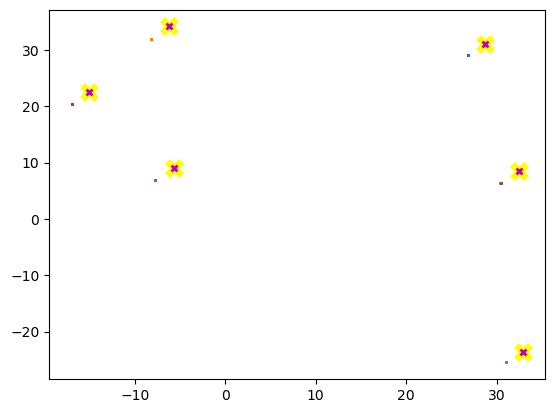

In [ ]:
plot_data(centroids+2, X, n_samples)

All the computation is happening in the <tt>for</tt> loop, which isn't accelerated by pytorch. Each iteration launches a new cuda kernel, which takes time and slows the algorithm down as a whole. Furthermore, each iteration doesn't have enough processing to do to fill up all of the threads of the GPU. But at least the results are correct...

We should be able to accelerate this algorithm with a GPU.

> Homework: make one animation for another cluster or for a diffusion

## Animation

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [ ]:
def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [ ]:
# create your own animation
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

> Homework: make one animation for another cluster or for a diffusion

## GPU batched algorithm

To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [ ]:
bs=5
X = data.clone()
x = X[:bs]
x.shape,X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

Result of the distance calculation should have a shape 1500 * 5. 1500 times 5 distances

X and x are not broadcastable this time. 5 and 1500 are not compatible

In [ ]:
# X - x

We need to insert dimensions

In [ ]:
X[None,:].shape, x[:, None].shape

(torch.Size([1, 1500, 2]), torch.Size([5, 1, 2]))

In [ ]:
(X[None, :] - x[:, None]).shape

torch.Size([5, 1500, 2])

In [ ]:
((X[None, :] - x[:, None])**2).sum(2).shape

torch.Size([5, 1500])

In [ ]:
def dist_b(a,b): return (((a[None]-b[:,None])**2).sum(2)).sqrt()

In [ ]:
dist_b(X, x)

tensor([[ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617],
        [ 3.899,  0.000,  4.978,  ..., 21.499, 26.508, 25.500],
        [ 4.834,  4.978,  0.000,  ..., 19.373, 24.757, 23.396],
        [ 3.726,  0.185,  4.969,  ..., 21.335, 26.336, 25.333],
        [ 6.273,  5.547,  1.615,  ..., 20.775, 26.201, 24.785]])

In [ ]:
dist_b(X, x).shape

torch.Size([5, 1500])

In [ ]:
X[None,:].shape, x[:,None].shape, (X[None,:]-x[:,None]).shape

(torch.Size([1, 1500, 2]), torch.Size([5, 1, 2]), torch.Size([5, 1500, 2]))

In [ ]:
weight = gaussian(dist_b(X, x), 2)
weight

tensor([[    0.199,     0.030,     0.011,  ...,     0.000,     0.000,     0.000],
        [    0.030,     0.199,     0.009,  ...,     0.000,     0.000,     0.000],
        [    0.011,     0.009,     0.199,  ...,     0.000,     0.000,     0.000],
        [    0.035,     0.199,     0.009,  ...,     0.000,     0.000,     0.000],
        [    0.001,     0.004,     0.144,  ...,     0.000,     0.000,     0.000]])

In [ ]:
weight.shape,X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [ ]:
weight[...,None].shape, X[None].shape

(torch.Size([5, 1500, 1]), torch.Size([1, 1500, 2]))

In [ ]:
num = (weight[...,None]*X[None]).sum(1)
num.shape

torch.Size([5, 2])

In [ ]:
num

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

can use einsum

In [ ]:
torch.einsum('ij,jk->ik', weight, X)

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

Actually, this is a matrix multiplication

In [ ]:
weight@X

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

Now we need to do the sum

In [ ]:
div = weight.sum(1, keepdim=True)
div.shape

torch.Size([5, 1])

In [ ]:
num/div

tensor([[26.376, 27.692],
        [26.101, 29.643],
        [28.892, 28.990],
        [26.071, 29.559],
        [29.323, 29.685]])

In [ ]:
from fastcore.all import chunked

Group code together into one fct

In [ ]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X, X[s]), 2.5)
#             weight = tri(dist_b(X, X[s]), 8)
            div = weight.sum(1, keepdim=True)
            X[s] = weight@X/div
    return X

Although each iteration still has to launch a new cuda kernel, there are now fewer iterations, and the acceleration from updating a batch of points more than makes up for it.

In [ ]:
data = data.cuda()

In [ ]:
X = meanshift(data).cpu()

In [ ]:
%timeit -n 5 _=meanshift(data, 1250).cpu()

16.6 ms ± 826 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


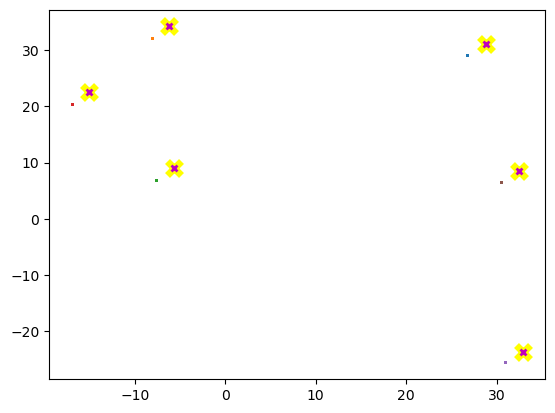

In [ ]:
plot_data(centroids+2, X, n_samples)

**Homework:** implement k-means clustering, dbscan, locality sensitive hashing, or some other clustering, fast nearest neighbors, or similar algorithm of your choice, on the GPU. Check if your version is faster than a pure python or CPU version.

Bonus: Implement it in APL too!

Super bonus: Invent a new meanshift algorithm which picks only the closest points, to avoid quadratic time.

Super super bonus: Publish a paper that describes it :D